In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Identification of Countries

In [ ]:
#reading data
time_series_init = pd.read_csv('time_series_covid_19_confirmed.csv')
time_series_init.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)
time_series_init["Total Cases"] = time_series_init.sum(axis=1)
time_series_init

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,02-01-20,02-02-20,02-03-20,02-04-20,02-05-20,02-06-20,02-07-20,02-08-20,02-09-20,02-10-20,02-11-20,02-12-20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,05-01-20,05-02-20,05-03-20,05-04-20,05-05-20,05-06-20,05-07-20,05-08-20,05-09-20,05-10-20,05-11-20,05-12-20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,Total Cases
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,197692
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,42303
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,248927
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,42336
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,1963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Sao Tome and Principe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174,174,187,208,208,208,208,208,220,235,235,235,235,246,251,251,251,251,251,251,299,441,443,5859
262,Yemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34,34,51,56,65,70,85,106,122,128,130,167,184,197,209,212,222,233,249,256,2952
263,Comoros,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,8,8,8,11,11,11,11,11,11,11,11,11,11,11,34,34,78,78,87,87,87,87,731
264,Tajikistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,15,15,76,128,230,293,379,461,522,612,612,661,729,801,907,1118,1322,1524,1729,1936,2140,2350,2551,2738,2929,3100,3266,3424,36568


In [ ]:
#adding all cases for each country
country_list = time_series_init['Country/Region'].unique()
cons_by_country = []
for c in country_list:
  cons = time_series_init.loc[time_series_init['Country/Region'] == c, 'Total Cases'].sum()
  cons_by_country.append([c, cons])

cons_by_country = sorted(cons_by_country, key = lambda x: x[1], reverse=True)

#dataframe containing countries and their total cases
cons = pd.DataFrame(data=cons_by_country, columns=["Country/Region", "Total Cases"])

#finding the difference of cases of all countries from cases of Pakistan
cons['difference'] = cons['Total Cases'] - cons.loc[cons['Country/Region'] == 'Pakistan', 'Total Cases'].item()

In [ ]:
#sorting to find the closest countries
cons.sort_values('difference')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cons)

                       Country/Region  Total Cases  difference
0                                  US     58797943    57551165
1                               Italy     12127486    10880708
2                               Spain     12126950    10880172
3                      United Kingdom      9419156     8172378
4                             Germany      9227781     7981003
5                               China      8955716     7708938
6                              France      8930573     7683795
7                              Russia      7829722     6582944
8                              Brazil      7113230     5866452
9                              Turkey      6028548     4781770
10                               Iran      5920456     4673678
11                             Canada      2986824     1740046
12                              India      2835126     1588348
13                               Peru      2660991     1414213
14                            Belgium      2538548     

As we can see from the differences above, the following 5 countries have the most similar amount of cases per number of days as of Pakistan:

*   Mexico
*   Chile
*   Portugal
*   Ecuador
*   Sweden



# Processing time series data for prediction

In [ ]:
dataset = pd.read_csv('time_series_covid_19_confirmed.csv', index_col='Country/Region')
dataset.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)

In [ ]:
#making data arrays for each country, each array entry refers to the total new cases reported on that day
mexico_data = dataset.loc['Mexico'].values.astype(int)
chile_data = dataset.loc['Chile'].values.astype(int)
portugal_data = dataset.loc['Portugal'].values.astype(int)
ecuador_data = dataset.loc['Ecuador'].values.astype(int)
sweden_data = dataset.loc['Sweden'].values.astype(int)
pakistan_data = dataset.loc['Pakistan'].values.astype(int)

In [ ]:
#splitting train-test data
train_mexico = mexico_data[:-18]
test_mexico = mexico_data[-18:]

train_chile = chile_data[:-18]
test_chile = chile_data[-18:]

train_portugal = portugal_data[:-18]
test_portugal = portugal_data[-18:]

train_ecuador = ecuador_data[:-18]
test_ecuador = ecuador_data[-18:]

train_sweden = sweden_data[:-18]
test_sweden = sweden_data[-18:]

train_pakistan = pakistan_data[:-18]
test_pakistan = pakistan_data[-18:]

In [ ]:
#scaling the data to normalize the values
scaler = MinMaxScaler(feature_range=(-1, 1))
train_mexico_normalized = scaler.fit_transform(train_mexico.reshape(-1, 1))
test_mexico_normalized = scaler.fit_transform(test_mexico.reshape(-1, 1))

train_chile_normalized = scaler.fit_transform(train_chile.reshape(-1, 1))
test_chile_normalized = scaler.fit_transform(test_chile.reshape(-1, 1))

train_portugal_normalized = scaler.fit_transform(train_portugal.reshape(-1, 1))
test_portugal_normalized = scaler.fit_transform(test_portugal.reshape(-1, 1))

train_ecuador_normalized = scaler.fit_transform(train_ecuador.reshape(-1, 1))
test_ecuador_normalized = scaler.fit_transform(test_ecuador.reshape(-1, 1))

train_sweden_normalized = scaler.fit_transform(train_sweden.reshape(-1, 1))
test_sweden_normalized = scaler.fit_transform(test_sweden.reshape(-1, 1))

train_pakistan_normalized = scaler.fit_transform(train_pakistan.reshape(-1, 1))
test_pakistan_normalized = scaler.fit_transform(test_pakistan.reshape(-1, 1))

In [ ]:
#function to create input sequences for LSTM
def create_input_sequences(data, tw):
    input_seq = []
    L = len(data)
    for i in range(L-tw):
        train_seq = data[i:i+tw]
        train_label = data[i+tw:i+tw+1]
        input_seq.append((train_seq ,train_label))
    return input_seq

In [ ]:
#converting data to tensors for LSTM
train_mexico_normalized = torch.FloatTensor(train_mexico_normalized).view(-1)
train_chile_normalized = torch.FloatTensor(train_chile_normalized).view(-1)
train_portugal_normalized = torch.FloatTensor(train_portugal_normalized).view(-1)
train_ecuador_normalized = torch.FloatTensor(train_ecuador_normalized).view(-1)
train_sweden_normalized = torch.FloatTensor(train_sweden_normalized).view(-1)
train_pakistan_normalized = torch.FloatTensor(train_pakistan_normalized).view(-1)

In [ ]:
#selecting train window as 18 for optimal data in each seuqence
train_window = 18

#creating input sequences
train_mexico_input_seq = create_input_sequences(train_mexico_normalized, train_window)
train_chile_input_seq = create_input_sequences(train_chile_normalized, train_window)
train_portugal_input_seq = create_input_sequences(train_portugal_normalized, train_window)
train_ecuador_input_seq = create_input_sequences(train_ecuador_normalized, train_window)
train_sweden_input_seq = create_input_sequences(train_sweden_normalized, train_window)
train_pakistan_input_seq = create_input_sequences(train_pakistan_normalized, train_window)

# Developing LSTM model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) , 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Mexico

## Training Model on Mexico

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_mexico_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000996
epoch:  26 loss: 0.00358827
epoch:  51 loss: 0.00182115
epoch:  76 loss: 0.00106527
epoch: 101 loss: 0.00098702
epoch: 126 loss: 0.00145192
epoch: 149 loss: 0.0006434011


## One month predictions using Mexico

In [ ]:
test_predict = 49
model.eval()
test_inputs_mexico = test_mexico_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_mexico[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_mexico = np.append(test_inputs_mexico, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_mexico = scaler.inverse_transform(np.array(test_inputs_mexico[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_mexico)

Predicted Data: 
 [[ 61362.44997782]
 [ 63844.20979476]
 [ 66618.6618489 ]
 [ 69802.94143444]
 [ 73562.49897683]
 [ 78120.00592899]
 [ 83760.17443287]
 [ 90806.11074781]
 [ 99518.95945501]
 [109861.21101499]
 [121134.12100339]
 [131846.89219975]
 [140441.36892128]
 [146347.15470719]
 [149991.47836852]
 [152104.05658054]
 [153288.03064609]
 [153947.27651882]
 [154324.31626749]
 [154532.68504   ]
 [154590.67212915]
 [154547.72458243]
 [154490.44515562]
 [154463.28603673]
 [154507.54585052]
 [154637.13737607]
 [154806.17935967]
 [154953.53801942]
 [155046.61279392]
 [155080.70425558]
 [155073.77878332]
 [155050.05491853]
 [155025.32108903]
 [155006.15237117]
 [154993.22207475]
 [154984.65455103]
 [154978.57415128]
 [154973.88846469]
 [154970.13029671]
 [154966.90802836]
 [154963.92622781]
 [154961.09557843]
 [154958.57410192]
 [154956.56104302]
 [154955.35870409]
 [154955.05640173]
 [154955.48924375]
 [154956.34118676]
 [154957.24809384]]


## Comparing Pakistan timeline to Mexico Prediction

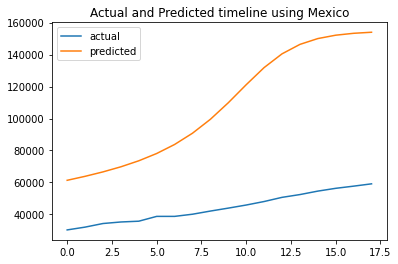

In [ ]:
plt.title('Actual and Predicted timeline using Mexico')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_mexico[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Chile

## Training Model on chile

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_chile_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00096018
epoch:  26 loss: 0.00037406
epoch:  51 loss: 0.00005006
epoch:  76 loss: 0.00006343
epoch: 101 loss: 0.00037429
epoch: 126 loss: 0.00174460
epoch: 149 loss: 0.0005461471


## One month predictions using chile

In [ ]:
test_predict = 49
model.eval()
test_inputs_chile = test_chile_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_chile[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_chile = np.append(test_inputs_chile, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_chile = scaler.inverse_transform(np.array(test_inputs_chile[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_chile)

Predicted Data: 
 [[60796.63958126]
 [62308.88481069]
 [63599.75711322]
 [64806.51721919]
 [65963.59324515]
 [67062.13597655]
 [68063.25146651]
 [68916.03955507]
 [69538.48355067]
 [69760.96091175]
 [69365.16124046]
 [68082.46484268]
 [65302.70875621]
 [60751.5432831 ]
 [53887.3070043 ]
 [51696.0580382 ]
 [53218.14355299]
 [58985.82010081]
 [64583.22913814]
 [69164.26758087]
 [71296.75309038]
 [70878.03683901]
 [65930.63198209]
 [63225.51022613]
 [65554.43730593]
 [68408.80024087]
 [74311.33284116]
 [77997.8482933 ]
 [78979.48589253]
 [71851.12409079]
 [62416.98195136]
 [66530.05977523]
 [70442.72831035]
 [79007.05037141]
 [76560.98456216]
 [85142.80580759]
 [76973.20818329]
 [65255.21980357]
 [50644.16219278]
 [43491.71389223]
 [35099.48152927]
 [30209.28310001]
 [28075.7120502 ]
 [28047.01050222]
 [29139.5003159 ]
 [30236.82696736]
 [30888.32204804]
 [31132.61327264]
 [31378.19443515]]


## Comparing Pakistan timeline to Chile Prediction

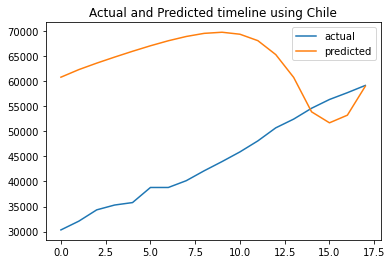

In [ ]:
plt.title('Actual and Predicted timeline using Chile')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_chile[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Portugal

## Training Model on portugal

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_portugal_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00027771
epoch:  26 loss: 0.00002724
epoch:  51 loss: 0.00025726
epoch:  76 loss: 0.00003231
epoch: 101 loss: 0.00003590
epoch: 126 loss: 0.00014697
epoch: 149 loss: 0.0001237251


## One month predictions using portugal

In [ ]:
test_predict = 49
model.eval()
test_inputs_portugal = test_portugal_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_portugal[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_portugal = np.append(test_inputs_portugal, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_portugal = scaler.inverse_transform(np.array(test_inputs_portugal[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_portugal)

Predicted Data: 
 [[59242.45848745]
 [58230.31669065]
 [57313.45939556]
 [56526.44783482]
 [56381.83136666]
 [56915.59857181]
 [57878.63942298]
 [58972.74981779]
 [60084.22971612]
 [61139.73214895]
 [62286.08331162]
 [61811.56994557]
 [45028.40009574]
 [45466.65864886]
 [37435.27224675]
 [29231.23877656]
 [27755.23376024]
 [27903.67624265]
 [28620.84565234]
 [28390.38647836]
 [28278.05538702]
 [31680.04505977]
 [34531.53268704]
 [36948.14978054]
 [38398.13618234]
 [43268.92564065]
 [49721.3812314 ]
 [51729.62132955]
 [56019.85864246]
 [71441.08357364]
 [76774.02528024]
 [74526.898471  ]
 [47442.48347464]
 [22347.91880244]
 [18488.13600415]
 [26721.9625743 ]
 [28425.35736507]
 [30883.23271909]
 [33368.59783521]
 [35935.82935053]
 [39278.21650589]
 [43774.27212984]
 [47992.69717348]
 [50899.94047767]
 [52526.32030684]
 [53324.24051696]
 [53821.45060682]
 [54249.97107339]
 [54673.35325864]]


## Comparing Pakistan timeline to Portugal Prediction

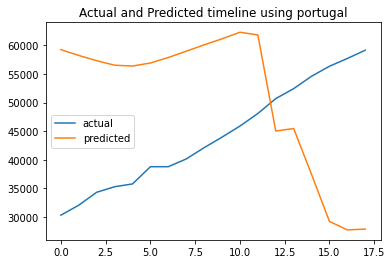

In [ ]:
plt.title('Actual and Predicted timeline using portugal')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_portugal[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Ecuador

## Training Model on ecuador

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_ecuador_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00552547
epoch:  26 loss: 0.00023977
epoch:  51 loss: 0.00004560
epoch:  76 loss: 0.00029454
epoch: 101 loss: 0.00017025
epoch: 126 loss: 0.00000736
epoch: 149 loss: 0.0001100889


## One month predictions using ecuador

In [ ]:
test_predict = 49
model.eval()
test_inputs_ecuador = test_ecuador_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_ecuador[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_ecuador = np.append(test_inputs_ecuador, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_ecuador = scaler.inverse_transform(np.array(test_inputs_ecuador[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_ecuador)

Predicted Data: 
 [[61498.1459499 ]
 [64097.8638044 ]
 [65477.44467348]
 [65832.25489289]
 [67208.2562272 ]
 [66985.95406407]
 [66217.72303748]
 [65345.65286767]
 [68446.49528408]
 [69971.83741975]
 [70153.03504997]
 [70517.62715542]
 [70461.41265738]
 [70752.12447059]
 [70844.17897463]
 [70947.53202939]
 [70991.27140218]
 [71044.21038544]
 [71082.91882861]
 [71104.26377994]
 [71121.78529346]
 [71132.716272  ]
 [71143.46002918]
 [71149.29137301]
 [71155.24123311]
 [71159.30170345]
 [71163.24881041]
 [71163.62497073]
 [71164.69848764]
 [71165.3821032 ]
 [71165.95579064]
 [71181.01937985]
 [70982.95636964]
 [70905.41066128]
 [70901.24369806]
 [70886.25396681]
 [70895.97230065]
 [70894.76996171]
 [70894.6359868 ]
 [70895.3848722 ]
 [70896.38624877]
 [70897.70366871]
 [70898.39243716]
 [70898.88196087]
 [70899.12929916]
 [70899.20831001]
 [70899.2838856 ]
 [70899.22548628]
 [70899.21002764]]


## Comparing Pakistan timeline to Ecuador Prediction

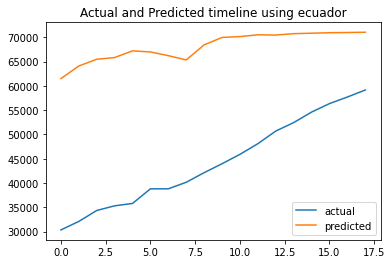

In [ ]:
plt.title('Actual and Predicted timeline using ecuador')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_ecuador[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Sweden

## Training Model on sweden

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_sweden_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00647022
epoch:  26 loss: 0.00004224
epoch:  51 loss: 0.00000003
epoch:  76 loss: 0.00002395
epoch: 101 loss: 0.00040132
epoch: 126 loss: 0.00020063
epoch: 149 loss: 0.0000058023


## One month predictions using sweden

In [ ]:
test_predict = 49
model.eval()
test_inputs_sweden = test_sweden_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_sweden[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_sweden = np.append(test_inputs_sweden, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_sweden = scaler.inverse_transform(np.array(test_inputs_sweden[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_sweden)

Predicted Data: 
 [[60201.37188083]
 [58035.94915503]
 [54520.30152404]
 [46586.93880937]
 [35990.58214796]
 [38766.0312846 ]
 [37771.13360456]
 [39054.46724197]
 [41710.24157283]
 [44242.10027671]
 [47026.72240061]
 [48923.41292772]
 [50306.20833582]
 [51219.5466425 ]
 [51914.25721972]
 [52657.40702674]
 [53368.54413024]
 [54002.05737334]
 [54324.78060186]
 [54541.79075605]
 [54787.67336211]
 [55094.75072584]
 [54716.54556721]
 [52853.55316517]
 [49279.46112682]
 [47766.77081729]
 [50382.91627158]
 [53248.5232226 ]
 [57791.39169824]
 [54575.74308991]
 [50737.08882195]
 [43653.75461328]
 [41653.13605575]
 [39764.90613008]
 [38765.28583446]
 [38823.69631869]
 [39202.04661679]
 [40600.10915291]
 [42064.81733614]
 [43807.00688083]
 [45479.02363127]
 [46948.53730558]
 [48182.36592561]
 [49166.70878744]
 [49988.01191339]
 [50720.93024549]
 [51413.02874137]
 [52055.13226676]
 [52625.95899311]]


## Comparing Pakistan timeline to Sweden Prediction

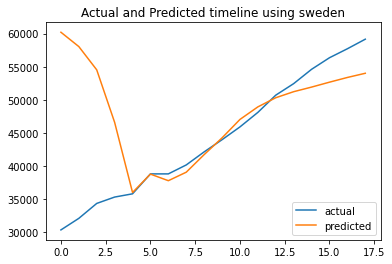

In [ ]:
plt.title('Actual and Predicted timeline using sweden')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_sweden[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Pakistan

## Training Model on Pakistan

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_pakistan_input_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00019436
epoch:  26 loss: 0.00062752
epoch:  51 loss: 0.00056285
epoch:  76 loss: 0.00036123
epoch: 101 loss: 0.00015123
epoch: 126 loss: 0.00033113
epoch: 149 loss: 0.0001512816


## One month predictions using pakistan

In [ ]:
test_predict = 49
model.eval()
test_inputs_pakistan = test_pakistan_normalized

for i in range(test_predict):
    seq = torch.FloatTensor(test_inputs_pakistan[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs_pakistan = np.append(test_inputs_pakistan, model(seq).item())

In [ ]:
#inverse normalizing our data to get the actual predicted values
predicted_pakistan = scaler.inverse_transform(np.array(test_inputs_pakistan[-test_predict:]).reshape(-1, 1))

print("Predicted Data: \n", predicted_pakistan)

Predicted Data: 
 [[59399.85667729]
 [60603.17465866]
 [62356.93714499]
 [63331.92580992]
 [64313.88804066]
 [65086.01979828]
 [66140.48134911]
 [66690.40541309]
 [66651.87045026]
 [67127.87128133]
 [67634.43900335]
 [68767.53352046]
 [72740.82741988]
 [76645.1585933 ]
 [82299.06467831]
 [89148.8789016 ]
 [97103.04830623]
 [95279.48145664]
 [62832.87270623]
 [36168.46647561]
 [36702.54371244]
 [32757.50821322]
 [34696.30722624]
 [29439.34303451]
 [25965.07303911]
 [25357.97432357]
 [24483.7347908 ]
 [24226.92206502]
 [24841.17641485]
 [25326.22914046]
 [25763.75169039]
 [26032.11030519]
 [26083.59274071]
 [26236.88580191]
 [26487.33643711]
 [26779.50823331]
 [26979.45032752]
 [27186.42438686]
 [27415.58159953]
 [27651.44099295]
 [27871.9413653 ]
 [28083.57534683]
 [28292.93003726]
 [28514.49705601]
 [28755.3839438 ]
 [29019.62197131]
 [29308.37397206]
 [29623.60662901]
 [29969.88024199]]


## Comparing Pakistan timeline to Pakistan Prediction

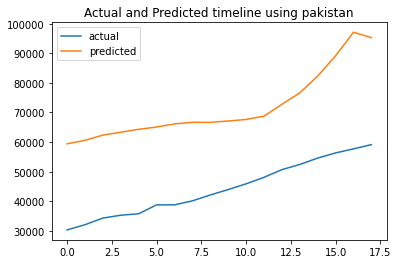

In [ ]:
plt.title('Actual and Predicted timeline using pakistan')
plt.autoscale(axis='both')
plt.plot(test_pakistan, label="actual")
plt.plot(predicted_pakistan[:18], label="predicted")
plt.legend(loc='best')
plt.show()

# Future timelines predicted by countries

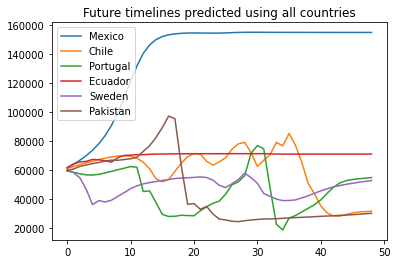

In [ ]:
plt.title('Future timelines predicted using all countries')
plt.autoscale(axis='x')
plt.plot(predicted_mexico, label="Mexico")
plt.plot(predicted_chile, label="Chile")
plt.plot(predicted_portugal, label="Portugal")
plt.plot(predicted_ecuador, label="Ecuador")
plt.plot(predicted_sweden, label="Sweden")
plt.plot(predicted_pakistan, label="Pakistan")
plt.legend(loc='best')
plt.show()